In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from agents import *
from environment import *

In [2]:
DISCOUNT = 0.6
EPSILON = 0.9

In [3]:
print(f"Discount: {DISCOUNT}. Epsilon: {EPSILON}")

Discount: 0.6. Epsilon: 0.9


In [4]:
def plot_heat_maps(value_array, policy_array, reward, penalty):
    _, axes = plt.subplots(2, 1, figsize=(15, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    matplotlib.rcParams.update({'font.size': 22})
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels

    axes = axes.flatten()
    axes[0].set_title(
        f'Value Function -- Reward: {reward} Penalty: {penalty} Discount: {DISCOUNT}', 
        fontsize=20
    )

    fig = sns.heatmap(
    #     np.flipud(results), 
        value_array,
        cmap="YlGnBu", 
        ax=axes[0],
    )
    fig.set_ylabel('# Old Vaccines ', fontsize=20)
    fig.set_xlabel('# New Vaccines ', fontsize=20)

    
    axes[1].set_title(
        f'Policy -- Reward: {reward} Penalty: {penalty} Discount: {DISCOUNT}', 
        fontsize=20
    )

    fig = sns.heatmap(
    #     np.flipud(results), 
        policy_array,
        cmap="YlGnBu", 
        ax=axes[1]
    )
    fig.set_ylabel('# Old Vaccines ', fontsize=20)
    fig.set_xlabel('# New Vaccines ', fontsize=20)
    


## Bellman Solution

In [5]:
centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
agent = bellman_agent(max_vax=15,max_delivery=15)

iteration = 0
while not agent.is_policy_stable:
    #if iteration % 10 == 0:
    print(f"Iteration: {iteration}")
    agent.policy_evaluation(centre, dist, verbose=False)
    agent.policy_improvement(centre, dist, verbose=False)
    iteration += 1

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2020-12-31 17:24:18,716 - INFO - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-31 17:24:18,716 - INFO - NumExpr defaulting to 8 threads.


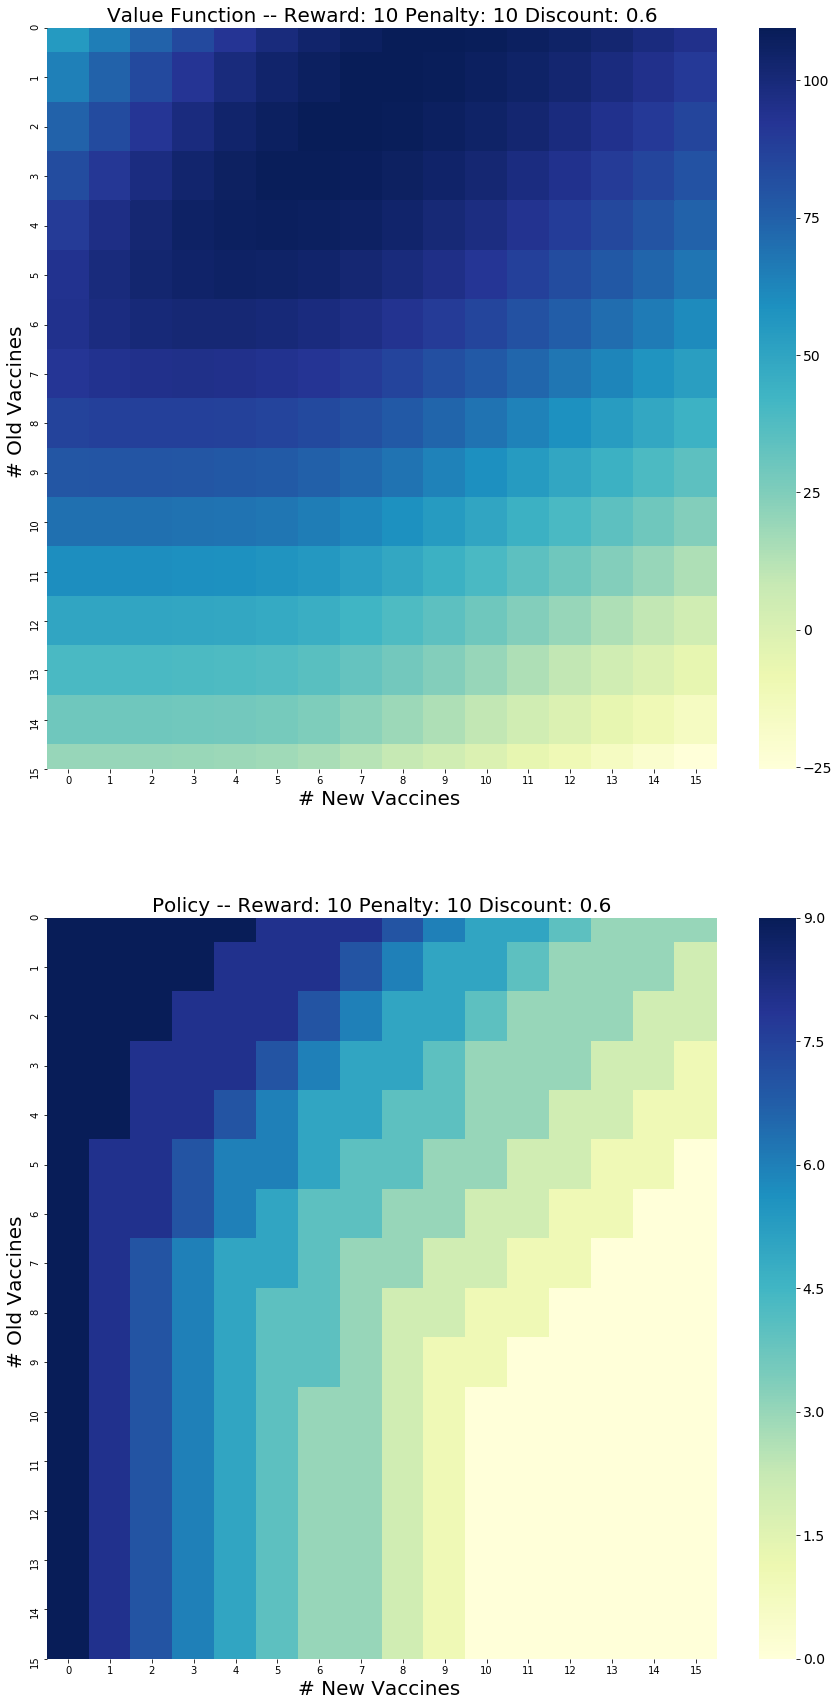

In [6]:
plot_heat_maps(agent.V, agent.policy, centre.fee_vaccine, centre.cost_vaccine)

## Model Free Solution

In [7]:
def epsilon_greedy(q_vec, curr_iter, no_decay_iters, epsilon=EPSILON, decay=False):
    """
    Returns the index of the action selected under an epsilon
    greedy policy
    """

    # adjust epsilon if required
    if decay == True and curr_iter > no_decay_iters:
            epsilon = epsilon / (curr_iter - no_decay_iters)

    
    # behave epsilon greedily
    if epsilon < np.random.random():
        return np.argmax(q_vec)
    else:
        return np.random.randint(np.array(q_vec).shape[-1])

In [8]:
def QLearning_policy(q_vec, action):
    """
    Identifies the action which maximises the q_vec
    state-action vector and returns a policy with all
    weight centred on highest value return
    """
    return np.eye(len(q_vec))[np.argmax(q_vec)]


def sarsa_policy(q_vec, action):
    """
    """
    return np.eye(len(q_vec))[action]


def expected_sarsa_policy(q_vec, action, epsilon=EPSILON):
    """
    """
    greedy = QLearning_policy(q_vec, action)
    return greedy - greedy * epsilon + epsilon / len(q_vec)

## Q-Learning

In [9]:
%%time

total_iters = 200000
no_decay_iters = 40000
decay=True

q_learning_alpha_rewards = []
alpha_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
for alpha in alpha_range:
    print(f'######## Alpha: {alpha} ############')
    centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
    dist = truncated_patient_arrival_distribution(max_arrivals=20, rate=6) 
    q_learning_agent = tabular_model_free_agent(
        max_vax=20,
        max_delivery=15,
        alpha = alpha,
        behaviour_policy=epsilon_greedy,
        target_policy=QLearning_policy
    )
    rewards = []
#     results = []
    for i in range(total_iters):
        if (i+1) % 20000 == 0:
            print(f"Alpha: {alpha}. Iteration: {i+1}")
        if i == 0:
            next_action = 0
            centre.delivery(next_action)

        centre.delivery(next_action)
        next_state = centre.get_state()
        patient_no = np.argmax(
            np.random.multinomial(1, dist.dist)
        )
        centre.treat_patients(patient_no)
        reward = centre.get_reward()
        next_action = q_learning_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
#         results.append([
#             next_state[0],
#             next_state[1],
#             patient_no,
#             next_action,
#             reward
#         ])
        rewards.append(reward)
    q_learning_alpha_rewards.append(rewards)

######## Alpha: 0.05 ############
Alpha: 0.05. Iteration: 20000
Alpha: 0.05. Iteration: 40000
Alpha: 0.05. Iteration: 60000
Alpha: 0.05. Iteration: 80000
Alpha: 0.05. Iteration: 100000
Alpha: 0.05. Iteration: 120000
Alpha: 0.05. Iteration: 140000
Alpha: 0.05. Iteration: 160000
Alpha: 0.05. Iteration: 180000
Alpha: 0.05. Iteration: 200000
######## Alpha: 0.1 ############
Alpha: 0.1. Iteration: 20000
Alpha: 0.1. Iteration: 40000
Alpha: 0.1. Iteration: 60000
Alpha: 0.1. Iteration: 80000
Alpha: 0.1. Iteration: 100000
Alpha: 0.1. Iteration: 120000
Alpha: 0.1. Iteration: 140000
Alpha: 0.1. Iteration: 160000
Alpha: 0.1. Iteration: 180000
Alpha: 0.1. Iteration: 200000
######## Alpha: 0.2 ############
Alpha: 0.2. Iteration: 20000
Alpha: 0.2. Iteration: 40000
Alpha: 0.2. Iteration: 60000
Alpha: 0.2. Iteration: 80000
Alpha: 0.2. Iteration: 100000
Alpha: 0.2. Iteration: 120000
Alpha: 0.2. Iteration: 140000
Alpha: 0.2. Iteration: 160000
Alpha: 0.2. Iteration: 180000
Alpha: 0.2. Iteration: 200000
##

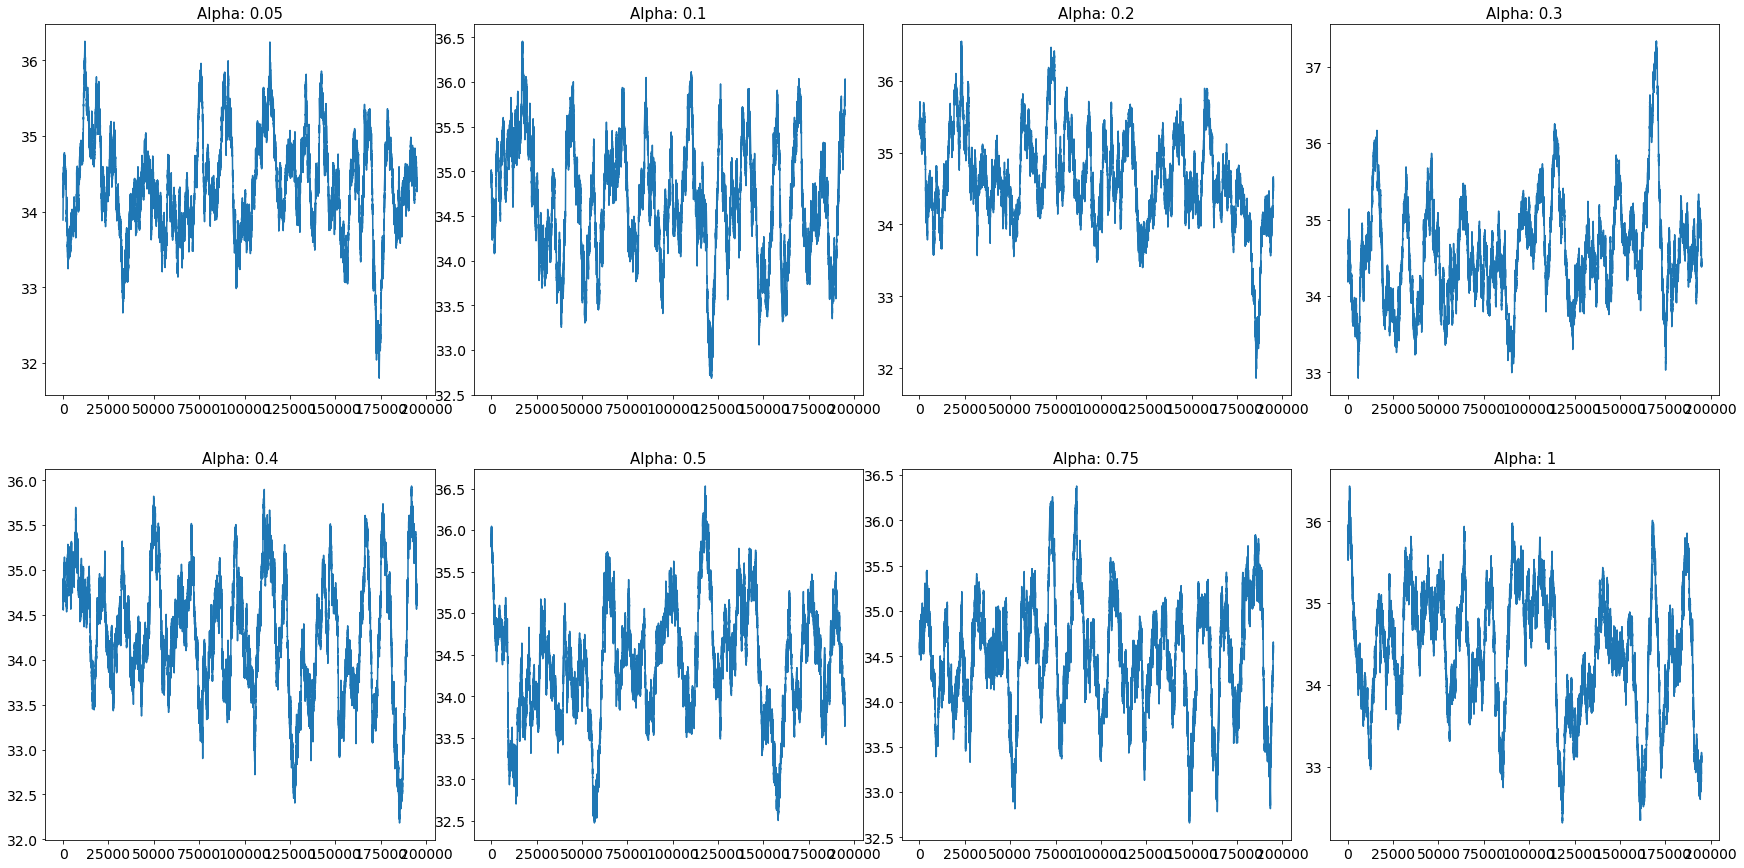

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

_, axes = plt.subplots(2, 4, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

alpha_idx = 0
q_learning_sma_rewards = [moving_average(rewards, 5000) for rewards in q_learning_alpha_rewards]
for i in range(2):
    for j in range(4):
        axes[i, j].plot(
            moving_average(q_learning_alpha_rewards[alpha_idx], 5000),
        )
        axes[i, j].set_title(f"Alpha: {alpha_range[alpha_idx]}", fontsize=15)
        alpha_idx += 1

/home/davide/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


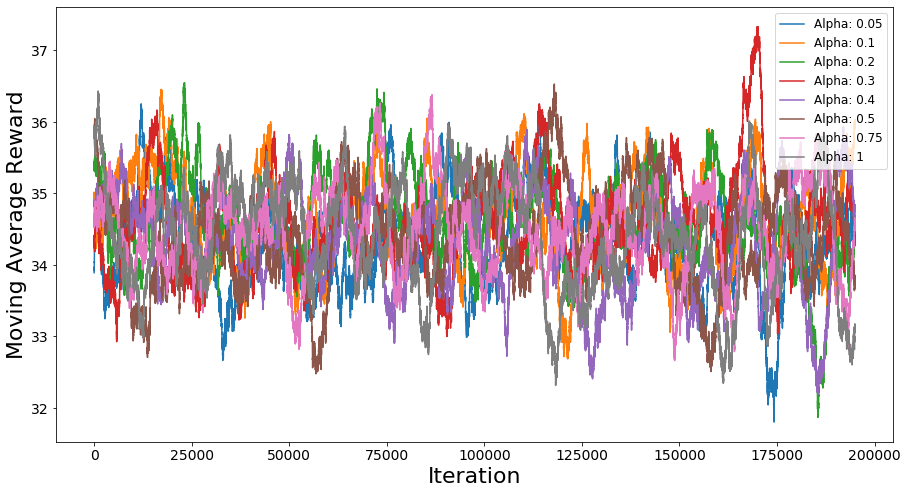

In [11]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(q_learning_sma_rewards)):
    plt.plot(q_learning_sma_rewards[i], label=f"Alpha: {alpha_range[i]}")
plt.legend(prop={'size': 12})
plt.xlabel('Iteration')
plt.ylabel('Moving Average Reward')
plt.show()

In [12]:
# Choosing algo with highest mean converged reward for the final quarter of actions
q_learning_average_final_rewards = []
for i in range(len(q_learning_alpha_rewards)):
    rewards = q_learning_alpha_rewards[i]
    q_learning_average_final_rewards.append(
        np.mean(rewards[int(0.75 * len(rewards)):])
    )
q_learning_optimal_alpha = alpha_range[int(np.argmax(q_learning_average_final_rewards))]    
print(
    f"Optimal Hyperparameter: {q_learning_optimal_alpha}"
)

Optimal Hyperparameter: 0.3


### Calculating Q-learning over best action

In [13]:
total_iters = 200000
no_decay_iters = 40000
decay=True


centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=20, rate=6) 
q_learning_agent = tabular_model_free_agent(
    max_vax=20,
    max_delivery=15,
    alpha=q_learning_optimal_alpha,
    behaviour_policy=epsilon_greedy,
    target_policy=QLearning_policy
)
rewards = []
q_learning_visits = np.zeros((16,16))
for i in range(total_iters):
    if (i+1) % 20000 == 0:
        print(f"Alpha: {q_learning_optimal_alpha}. Iteration: {i+1}")
    if i == 0:
        next_action = 0
        centre.delivery(next_action)

    centre.delivery(next_action)
    next_state = centre.get_state()
    patient_no = np.argmax(
        np.random.multinomial(1, dist.dist)
    )
    centre.treat_patients(patient_no)
    reward = centre.get_reward()
    next_action = q_learning_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
    q_learning_visits[next_state[0],next_state[1]] += 1

Alpha: 0.3. Iteration: 20000
Alpha: 0.3. Iteration: 40000
Alpha: 0.3. Iteration: 60000
Alpha: 0.3. Iteration: 80000
Alpha: 0.3. Iteration: 100000
Alpha: 0.3. Iteration: 120000
Alpha: 0.3. Iteration: 140000
Alpha: 0.3. Iteration: 160000
Alpha: 0.3. Iteration: 180000
Alpha: 0.3. Iteration: 200000


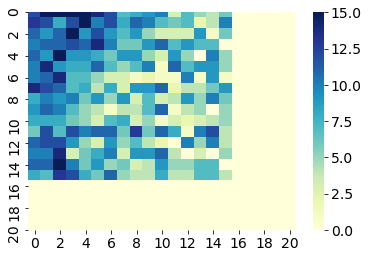

In [14]:
fig = sns.heatmap(
    np.argmax(q_learning_agent.q, axis=-1),
    cmap="YlGnBu",
)

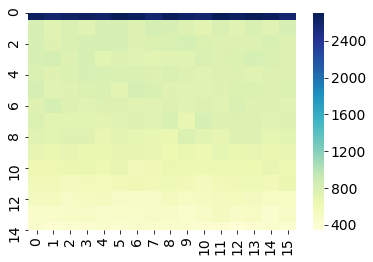

In [15]:
fig = sns.heatmap(
    q_learning_visits,
    cmap="YlGnBu",
)

In [16]:
q_learning_visits

array([[2665., 2598., 2623., 2652., 2615., 2702., 2678., 2589., 2695.,
        2619., 2598., 2706., 2664., 2702., 2678., 2589.],
       [ 812.,  747.,  792.,  741.,  808.,  806.,  769.,  827.,  808.,
         775.,  719.,  790.,  746.,  796.,  733.,  811.],
       [ 818.,  758.,  788.,  816.,  833.,  817.,  750.,  780.,  795.,
         820.,  781.,  771.,  774.,  760.,  804.,  771.],
       [ 812.,  832.,  759.,  822.,  730.,  775.,  740.,  729.,  735.,
         748.,  792.,  767.,  784.,  822.,  793.,  759.],
       [ 789.,  756.,  779.,  809.,  802.,  790.,  788.,  766.,  793.,
         776.,  742.,  775.,  766.,  737.,  767.,  766.],
       [ 828.,  748.,  755.,  780.,  790.,  715.,  835.,  799.,  751.,
         748.,  735.,  753.,  781.,  781.,  765.,  780.],
       [ 758.,  817.,  764.,  740.,  764.,  766.,  747.,  743.,  764.,
         742.,  764.,  743.,  790.,  758.,  774.,  743.],
       [ 778.,  723.,  725.,  724.,  717.,  746.,  760.,  746.,  799.,
         678.,  821.,  763

## SARSA

In [9]:
%%time

total_iters = 500000
no_decay_iters = 100000
decay=True

sarsa_alpha_rewards = []
alpha_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
for alpha in alpha_range:
    print(f'######## Alpha: {alpha} ############')
    centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
    dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
    sarsa_agent = tabular_model_free_agent(
        max_vax=12,
        max_delivery=10,
        alpha = alpha,
        behaviour_policy=epsilon_greedy,
        target_policy=sarsa_policy
    )
    rewards = []
#     results = []
    for i in range(total_iters):
        if (i+1) % 50000 == 0:
            print(f"Alpha: {alpha}. Iteration: {i+1}")
        if i == 0:
            next_action = 0
            centre.delivery(next_action)

        centre.delivery(next_action)
        next_state = centre.get_state()
        patient_no = np.argmax(
            np.random.multinomial(1, dist.dist)
        )
        centre.treat_patients(patient_no)
        reward = centre.get_reward()
        next_action = sarsa_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
#         results.append([
#             next_state[0],
#             next_state[1],
#             patient_no,
#             next_action,
#             reward
#         ])
        rewards.append(reward)
    sarsa_alpha_rewards.append(rewards)

######## Alpha: 0.05 ############
Alpha: 0.05. Iteration: 50000
Alpha: 0.05. Iteration: 100000
Alpha: 0.05. Iteration: 150000
Alpha: 0.05. Iteration: 200000
Alpha: 0.05. Iteration: 250000
Alpha: 0.05. Iteration: 300000
Alpha: 0.05. Iteration: 350000
Alpha: 0.05. Iteration: 400000
Alpha: 0.05. Iteration: 450000
Alpha: 0.05. Iteration: 500000
######## Alpha: 0.1 ############
Alpha: 0.1. Iteration: 50000
Alpha: 0.1. Iteration: 100000
Alpha: 0.1. Iteration: 150000
Alpha: 0.1. Iteration: 200000
Alpha: 0.1. Iteration: 250000
Alpha: 0.1. Iteration: 300000
Alpha: 0.1. Iteration: 350000
Alpha: 0.1. Iteration: 400000
Alpha: 0.1. Iteration: 450000
Alpha: 0.1. Iteration: 500000
######## Alpha: 0.2 ############
Alpha: 0.2. Iteration: 50000
Alpha: 0.2. Iteration: 100000
Alpha: 0.2. Iteration: 150000
Alpha: 0.2. Iteration: 200000
Alpha: 0.2. Iteration: 250000
Alpha: 0.2. Iteration: 300000
Alpha: 0.2. Iteration: 350000
Alpha: 0.2. Iteration: 400000
Alpha: 0.2. Iteration: 450000
Alpha: 0.2. Iteration: 

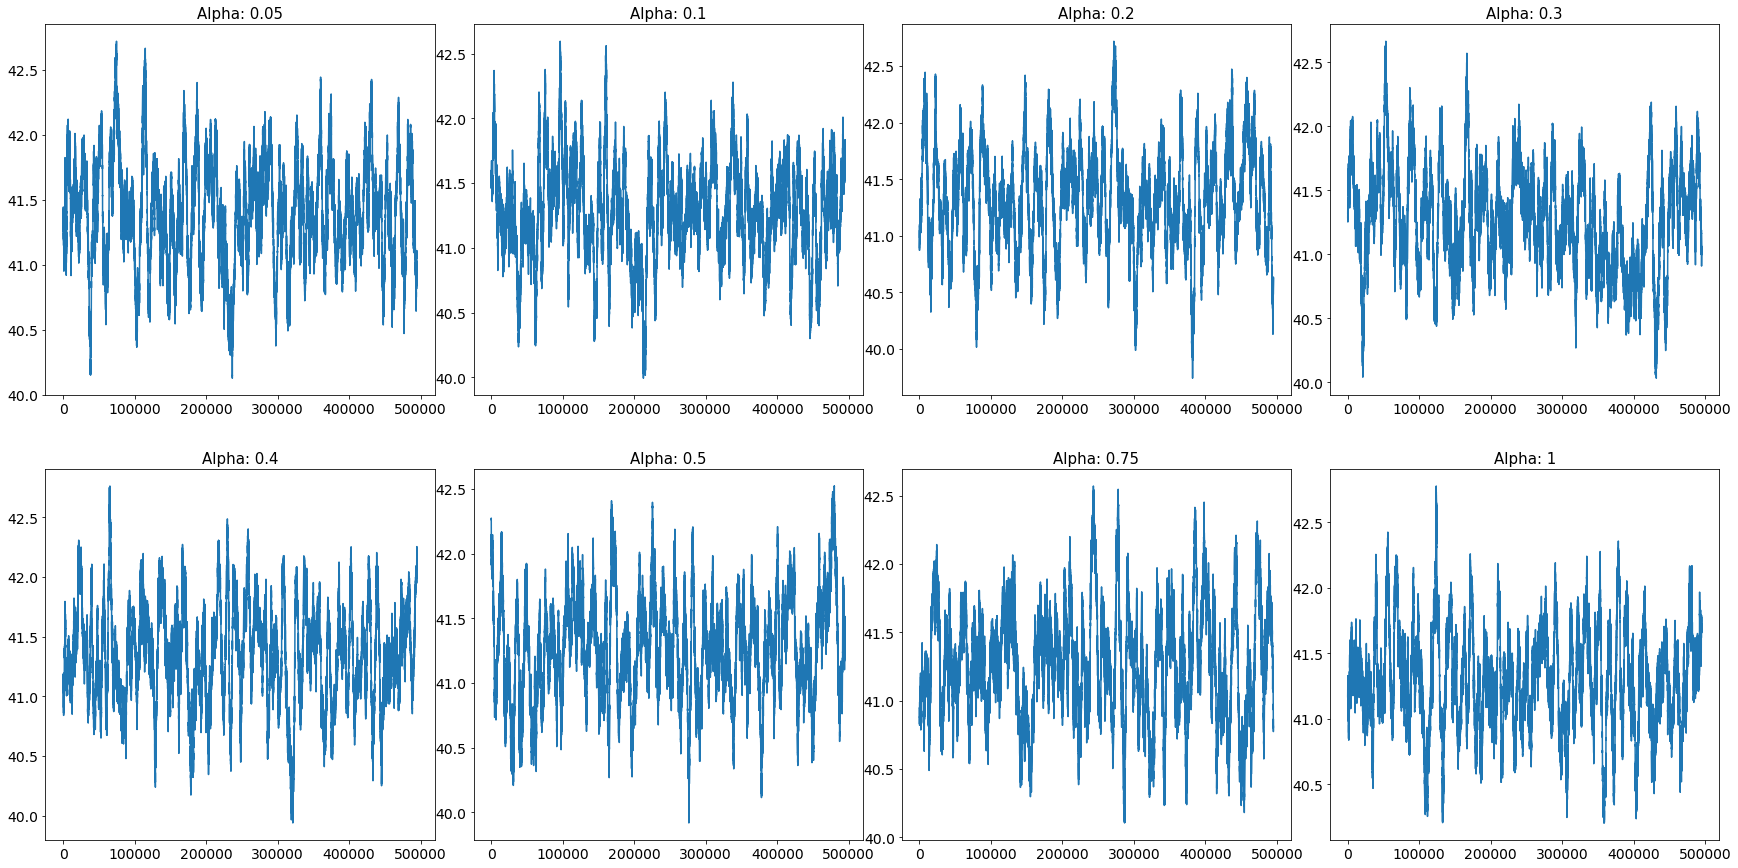

In [10]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

_, axes = plt.subplots(2, 4, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

alpha_idx = 0
sarsa_sma_rewards = [moving_average(rewards, 5000) for rewards in sarsa_alpha_rewards]
for i in range(2):
    for j in range(4):
        axes[i, j].plot(
            moving_average(sarsa_alpha_rewards[alpha_idx], 5000),
        )
        axes[i, j].set_title(f"Alpha: {alpha_range[alpha_idx]}", fontsize=15)
        alpha_idx += 1

/home/davide/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


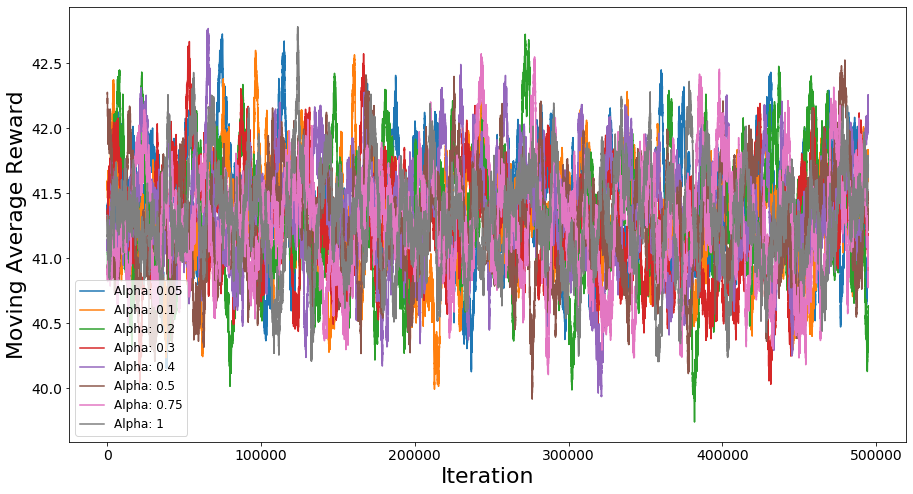

In [11]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(sarsa_sma_rewards)):
    plt.plot(sarsa_sma_rewards[i], label=f"Alpha: {alpha_range[i]}")
plt.legend(prop={'size': 12})
plt.xlabel('Iteration')
plt.ylabel('Moving Average Reward')
plt.show()

In [13]:
# Choosing algo with highest mean converged reward for the final quarter of actions
sarsa_average_final_rewards = []
for i in range(len(sarsa_alpha_rewards)):
    rewards = sarsa_alpha_rewards[i]
    sarsa_average_final_rewards.append(
        np.mean(rewards[int(0.75 * len(rewards)):])
    )
sarsa_optimal_alpha = alpha_range[int(np.argmax(sarsa_average_final_rewards))]    
print(
    f"Optimal Hyperparameter: {sarsa_optimal_alpha}"
)

Optimal Hyperparameter: 0.05


### Calculating SARSA over best action

In [16]:
total_iters = 500000
no_decay_iters = 100000
decay=True


centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
sarsa_agent = tabular_model_free_agent(
    max_vax=12,
    max_delivery=12,
    alpha=sarsa_optimal_alpha,
    behaviour_policy=epsilon_greedy,
    target_policy=sarsa_policy
)
sarsa_visits = np.zeros((13,13))
rewards = []
for i in range(total_iters):
    if (i+1) % 50000 == 0:
        print(f"Alpha: {sarsa_optimal_alpha}. Iteration: {i+1}")
    if i == 0:
        next_action = 0
        centre.delivery(next_action)

    centre.delivery(next_action)
    next_state = centre.get_state()
    patient_no = np.argmax(
        np.random.multinomial(1, dist.dist)
    )
    centre.treat_patients(patient_no)
    reward = centre.get_reward()
    next_action = sarsa_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
    sarsa_visits[next_state[0],next_state[1]] += 1

Alpha: 0.05. Iteration: 50000
Alpha: 0.05. Iteration: 100000
Alpha: 0.05. Iteration: 150000
Alpha: 0.05. Iteration: 200000
Alpha: 0.05. Iteration: 250000
Alpha: 0.05. Iteration: 300000
Alpha: 0.05. Iteration: 350000
Alpha: 0.05. Iteration: 400000
Alpha: 0.05. Iteration: 450000
Alpha: 0.05. Iteration: 500000


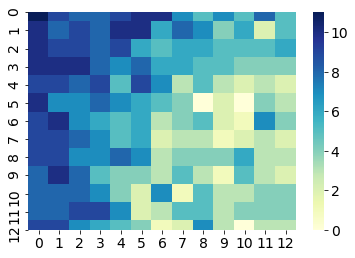

In [17]:
fig = sns.heatmap(
    np.argmax(sarsa_agent.q, axis=-1),
    cmap="YlGnBu",
)

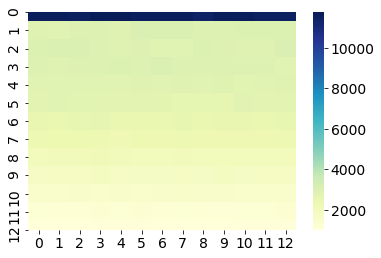

In [18]:
fig = sns.heatmap(
    sarsa_visits,
    cmap="YlGnBu",
)

In [19]:
sarsa_visits

array([[11629., 11705., 11577., 11753., 11733., 11618., 11602., 11622.,
        11456., 11650., 11655., 11512., 11542.],
       [ 2902.,  2796.,  2960.,  2909.,  2894.,  3036.,  3034.,  3042.,
         2978.,  2983.,  3009.,  3003.,  3002.],
       [ 2994.,  3043.,  3055.,  2924.,  2876.,  2946.,  2842.,  2841.,
         3001.,  2969.,  2865.,  2888.,  3041.],
       [ 2986.,  2899.,  2921.,  2940.,  2990.,  2928.,  3032.,  2943.,
         2938.,  2921.,  2984.,  2924.,  2852.],
       [ 2835.,  2779.,  2784.,  2836.,  2797.,  2885.,  2855.,  2895.,
         2843.,  2895.,  2757.,  2821.,  2876.],
       [ 2694.,  2786.,  2741.,  2746.,  2720.,  2730.,  2707.,  2671.,
         2690.,  2642.,  2790.,  2725.,  2769.],
       [ 2544.,  2457.,  2571.,  2637.,  2445.,  2485.,  2472.,  2567.,
         2484.,  2563.,  2550.,  2456.,  2589.],
       [ 2351.,  2382.,  2359.,  2349.,  2234.,  2368.,  2312.,  2349.,
         2292.,  2302.,  2315.,  2274.,  2317.],
       [ 2001.,  2025.,  2051., 

## Expected SARSA

In [19]:
%%time

total_iters = 1000000
no_decay_iters = 200000
decay=True

e_sarsa_alpha_rewards = []
alpha_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1]
for alpha in alpha_range:
    print(f'######## Alpha: {alpha} ############')
    centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
    dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
    e_sarsa_agent = tabular_model_free_agent(
        max_vax=12,
        max_delivery=10,
        alpha = alpha,
        behaviour_policy=epsilon_greedy,
        target_policy=expected_sarsa_policy
    )
    rewards = []
#     results = []
    for i in range(total_iters):
        if (i+1) % 100000 == 0:
            print(f"Alpha: {alpha}. Iteration: {i+1}")
        if i == 0:
            next_action = 0
            centre.delivery(next_action)

        centre.delivery(next_action)
        next_state = centre.get_state()
        patient_no = np.argmax(
            np.random.multinomial(1, dist.dist)
        )
        centre.treat_patients(patient_no)
        reward = centre.get_reward()
        next_action = e_sarsa_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)
#         results.append([
#             next_state[0],
#             next_state[1],
#             patient_no,
#             next_action,
#             reward
#         ])
        rewards.append(reward)
    e_sarsa_alpha_rewards.append(rewards)

######## Alpha: 0.05 ############
Alpha: 0.05. Iteration: 100000
Alpha: 0.05. Iteration: 200000
Alpha: 0.05. Iteration: 300000
Alpha: 0.05. Iteration: 400000
Alpha: 0.05. Iteration: 500000
Alpha: 0.05. Iteration: 600000
Alpha: 0.05. Iteration: 700000
Alpha: 0.05. Iteration: 800000
Alpha: 0.05. Iteration: 900000
Alpha: 0.05. Iteration: 1000000
######## Alpha: 0.1 ############
Alpha: 0.1. Iteration: 100000
Alpha: 0.1. Iteration: 200000
Alpha: 0.1. Iteration: 300000
Alpha: 0.1. Iteration: 400000
Alpha: 0.1. Iteration: 500000
Alpha: 0.1. Iteration: 600000
Alpha: 0.1. Iteration: 700000
Alpha: 0.1. Iteration: 800000
Alpha: 0.1. Iteration: 900000
Alpha: 0.1. Iteration: 1000000
######## Alpha: 0.2 ############
Alpha: 0.2. Iteration: 100000
Alpha: 0.2. Iteration: 200000
Alpha: 0.2. Iteration: 300000
Alpha: 0.2. Iteration: 400000
Alpha: 0.2. Iteration: 500000
Alpha: 0.2. Iteration: 600000
Alpha: 0.2. Iteration: 700000
Alpha: 0.2. Iteration: 800000
Alpha: 0.2. Iteration: 900000
Alpha: 0.2. Iterat

/home/davide/RL_projects/vaccine/RL-Exploration/vaccine_delivery/agents.py:128: RuntimeWarning: overflow encountered in double_scalars
  ] += self.alpha * delta
/home/davide/RL_projects/vaccine/RL-Exploration/vaccine_delivery/agents.py:122: RuntimeWarning: invalid value encountered in double_scalars
  ) - self.q[old_vaccines, new_vaccines, next_action]


Alpha: 0.75. Iteration: 900000
Alpha: 0.75. Iteration: 1000000
######## Alpha: 1 ############
Alpha: 1. Iteration: 100000
Alpha: 1. Iteration: 200000
Alpha: 1. Iteration: 300000
Alpha: 1. Iteration: 400000
Alpha: 1. Iteration: 500000
Alpha: 1. Iteration: 600000
Alpha: 1. Iteration: 700000
Alpha: 1. Iteration: 800000
Alpha: 1. Iteration: 900000
Alpha: 1. Iteration: 1000000
CPU times: user 6min 39s, sys: 4.18 s, total: 6min 43s
Wall time: 6min 39s


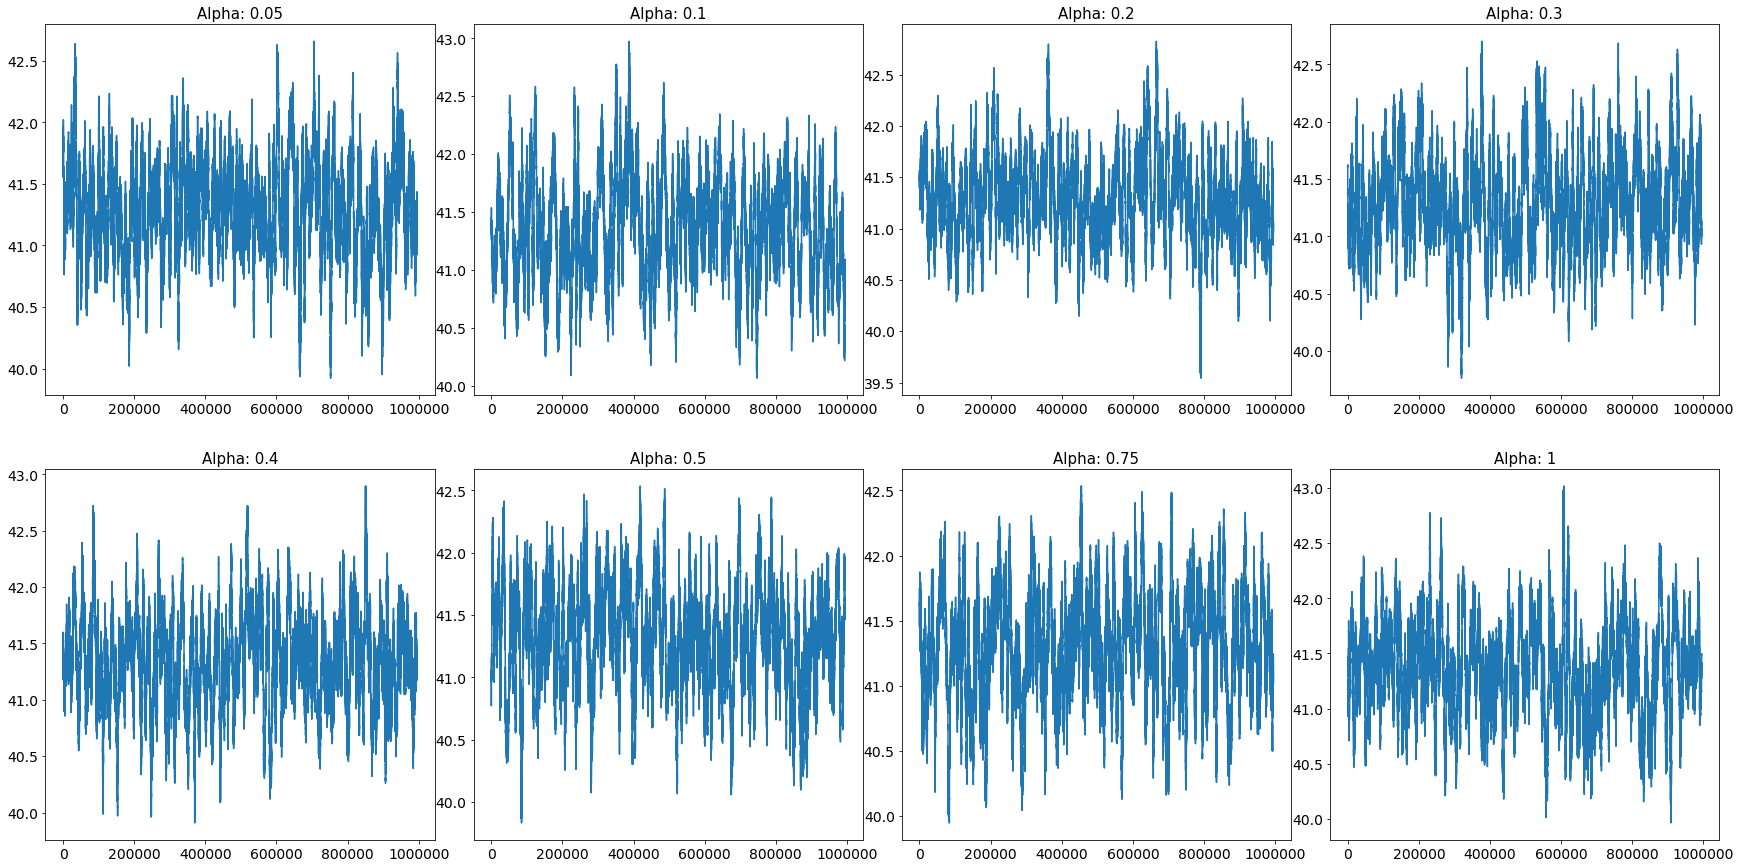

In [20]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

_, axes = plt.subplots(2, 4, figsize=(30, 15))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

alpha_idx = 0
e_sarsa_sma_rewards = [moving_average(rewards, 5000) for rewards in e_sarsa_alpha_rewards]
for i in range(2):
    for j in range(4):
        axes[i, j].plot(
            moving_average(e_sarsa_alpha_rewards[alpha_idx], 5000),
        )
        axes[i, j].set_title(f"Alpha: {alpha_range[alpha_idx]}", fontsize=15)
        alpha_idx += 1

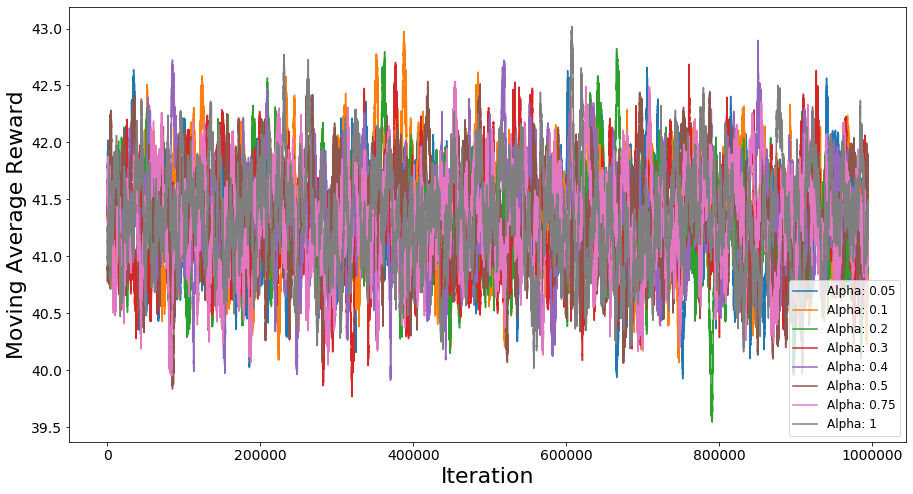

In [22]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(e_sarsa_sma_rewards)):
    plt.plot(e_sarsa_sma_rewards[i], label=f"Alpha: {alpha_range[i]}")
plt.legend(prop={'size': 12})
plt.xlabel('Iteration')
plt.ylabel('Moving Average Reward')
plt.show()

In [24]:
# Choosing algo with highest mean converged reward for the final quarter of actions
e_sarsa_average_final_rewards = []
for i in range(len(e_sarsa_alpha_rewards)):
    rewards = e_sarsa_alpha_rewards[i]
    e_sarsa_average_final_rewards.append(
        np.mean(rewards[int(0.75 * len(rewards)):])
    )
optimal_alpha = alpha_range[int(np.argmax(e_sarsa_average_final_rewards))]    
print(
    f"Optimal Hyperparameter: {optimal_alpha}"
)

Optimal Hyperparameter: 1


### Calculating Expected SARSA over best action

In [25]:
total_iters = 1000000
no_decay_iters = 200000
decay=True


centre = drug_centre(cost_vaccine=10, fee_vaccine=10) 
dist = truncated_patient_arrival_distribution(max_arrivals=10, rate=6) 
e_sarsa_agent = tabular_model_free_agent(
    max_vax=12,
    max_delivery=12,
    alpha=optimal_alpha,
    behaviour_policy=epsilon_greedy,
    target_policy=expected_sarsa_policy
)
rewards = []
for i in range(total_iters):
    if (i+1) % 100000 == 0:
        print(f"Alpha: {optimal_alpha}. Iteration: {i+1}")
    if i == 0:
        next_action = 0
        centre.delivery(next_action)

    centre.delivery(next_action)
    next_state = centre.get_state()
    patient_no = np.argmax(
        np.random.multinomial(1, dist.dist)
    )
    centre.treat_patients(patient_no)
    reward = centre.get_reward()
    next_action = e_sarsa_agent.step(reward, next_state, curr_iter=i+1, no_decay_iters=no_decay_iters, decay=decay)

Alpha: 1. Iteration: 100000
Alpha: 1. Iteration: 200000
Alpha: 1. Iteration: 300000
Alpha: 1. Iteration: 400000
Alpha: 1. Iteration: 500000
Alpha: 1. Iteration: 600000
Alpha: 1. Iteration: 700000
Alpha: 1. Iteration: 800000
Alpha: 1. Iteration: 900000
Alpha: 1. Iteration: 1000000


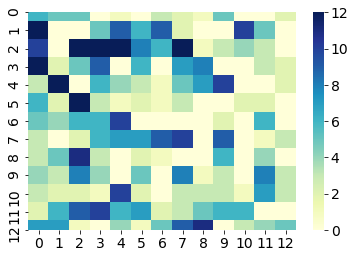

In [26]:
fig = sns.heatmap(
    np.argmax(e_sarsa_agent.q, axis=-1),
    cmap="YlGnBu",
)